# Medical Image Classification Tutorial with the MedNIST Dataset

## Introduction

In this tutorial, we introduce an end-to-end training and evaluation example based on the MedNIST dataset.  
We'll go through the following steps:
<ul>
    <li>Create a dataset for training and testing</li>
    <li>Use MONAI transforms to pre-process data</li>
    <li>Use the DenseNet from MONAI for classification</li>
    <li>Train the model with a PyTorch program</li>
    <li>Evaluate on test dataset</li>
</ul>


### Get the dataset

The MedNIST dataset was gathered from several sets from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions), [the RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4), and [the NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

The dataset is kindly made available by [Dr. Bradley J. Erickson M.D., Ph.D.](https://www.mayo.edu/research/labs/radiology-informatics/overview) (Department of Radiology, Mayo Clinic)
under the Creative Commons [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/).
If you use the MedNIST dataset, please acknowledge the source, e.g.

https://github.com/Project-MONAI/MONAI/blob/master/examples/notebooks/mednist_tutorial.ipynb.

The following commands download and unzip the dataset (~60MB).

In [1]:
!wget https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz

--2020-06-19 16:06:06--  https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.1, 2620:100:6020:1::a27d:4001
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/5wwskxctvcxiuea/MedNIST.tar.gz [following]
--2020-06-19 16:06:07--  https://www.dropbox.com/s/raw/5wwskxctvcxiuea/MedNIST.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc109b35e02abf70d4b89330689.dl.dropboxusercontent.com/cd/0/inline/A59l3imo42tWXnnchCo98auOItQNOG13dWU-ugkNOvGhf0_8qlrhDSOyDM2r8KN0U5VC72EmmcFP3A5k4ooNDcKC7nrWOFDMbFmzCKkg8YFZdcfBHNOt0nS6bJ-9fxLdu4M/file# [following]
--2020-06-19 16:06:07--  https://ucc109b35e02abf70d4b89330689.dl.dropboxusercontent.com/cd/0/inline/A59l3imo42tWXnnchCo98auOItQNOG13dWU-ugkNOvGhf0_8qlrhDSOyDM2r8KN0U5VC72EmmcFP3A5k4ooNDcKC7nrWOFDMbFmzCKkg8

In [2]:
# unzip the '.tar.gz' file to the current directory
import tarfile
datafile = tarfile.open('MedNIST.tar.gz')
datafile.extractall()
datafile.close()

In [8]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from monai.transforms import \
    Compose, LoadPNG, AddChannel, ScaleIntensity, ToTensor, RandRotate, RandFlip, RandZoom
from monai.networks.nets import densenet121
from monai.metrics import compute_roc_auc

np.random.seed(0)

## Read image filenames from the dataset folders
First of all, check the dataset files and show some statistics.  
There are 6 folders in the dataset: Hand, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT,  
which should be used as the labels to train our classification model.

In [9]:
data_dir = './MedNIST/'
class_names = sorted([x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x))])
num_class = len(class_names)
image_files = [[os.path.join(data_dir, class_names[i], x)
                for x in os.listdir(os.path.join(data_dir, class_names[i]))]
               for i in range(num_class)]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = Image.open(image_files_list[0]).size

print('Total image count: {}'.format(num_total))
print('Image dimensions: {} x {}'.format(image_width,image_height))
print('Label names: {}'.format(class_names))
print('Label counts: {}'.format(num_each))

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


## Randomly pick images from the dataset to visualize and check

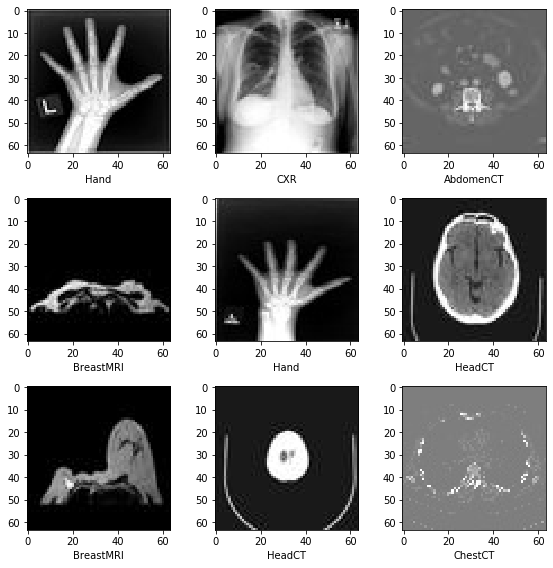

In [15]:
plt.subplots(3, 3, figsize=(8, 8))
for i,k in enumerate(np.random.randint(num_total, size=9)):
    im = Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()

## Prepare training, validation and test data lists
Randomly select 10% of the dataset as validation and 10% as test.

In [16]:
val_frac = 0.1
test_frac = 0.1
train_x = list()
train_y = list()
val_x = list()
val_y = list()
test_x = list()
test_y = list()

for i in range(num_total):
    rann = np.random.random()
    if rann < val_frac:
        val_x.append(image_files_list[i])
        val_y.append(image_class[i])
    elif rann < test_frac + val_frac:
        test_x.append(image_files_list[i])
        test_y.append(image_class[i])
    else:
        train_x.append(image_files_list[i])
        train_y.append(image_class[i])

print('Training count: {}, Validation count: {}, Test count: {}'.format(len(train_x), len(val_x), len(test_x)))

Training count: 47138, Validation count: 5919, Test count: 5897


## Define MONAI transforms, Dataset and Dataloader to pre-process data

In [17]:
train_transforms = Compose([
    LoadPNG(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    RandRotate(range_x=15, prob=0.5, keep_size=True),
    RandFlip(spatial_axis=0, prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ToTensor()
])

val_transforms = Compose([
    LoadPNG(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    ToTensor()
])

In [18]:
class MedNISTDataset(Dataset):

    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=10)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = DataLoader(val_ds, batch_size=300, num_workers=10)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = DataLoader(test_ds, batch_size=300, num_workers=10)

## Define network and optimizer
1. Set learning rate for how much the model is updated per batch.
2. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.  
   And as this is just a get start tutorial, let's just train 4 epochs.  
   If train 10 epochs, the model can achieve 100% accuracy on test dataset.
3. Use DenseNet from MONAI and move to GPU devide, this DenseNet can support both 2D and 3D classification tasks.
4. Use Adam optimizer.

In [19]:
device = torch.device('cuda:0')
model = densenet121(
    spatial_dims=2,
    in_channels=1,
    out_channels=num_class
).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
epoch_num = 4
val_interval = 1

## Model training
Execute a typical PyTorch training that run epoch loop and step loop, and do validation after every epoch.  
Will save the model weights to file if got best validation accuracy.

In [ ]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
for epoch in range(epoch_num):
    print('-' * 10)
    print('epoch {}/{}'.format(epoch + 1, epoch_num))
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print('{}/{}, train_loss: {:.4f}'.format(step, len(train_ds) // train_loader.batch_size, loss.item()))
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print('epoch {} average loss: {:.4f}'.format(epoch + 1, epoch_loss))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            auc_metric = compute_roc_auc(y_pred, y, to_onehot_y=True, softmax=True)
            metric_values.append(auc_metric)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if auc_metric > best_metric:
                best_metric = auc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')
            print('current epoch: {} current AUC: {:.4f} current accuracy: {:.4f} best AUC: {:.4f} at epoch {}'.format(
                epoch + 1, auc_metric, acc_metric, best_metric, best_metric_epoch))
print('train completed, best_metric: {:.4f} at epoch: {}'.format(best_metric, best_metric_epoch))

## Plot the loss and metric

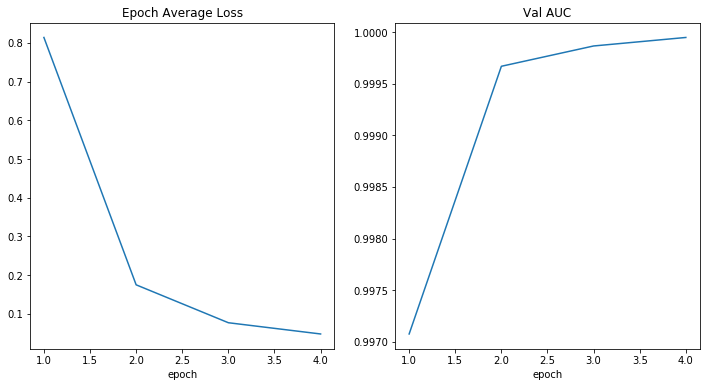

In [14]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title('Epoch Average Loss')
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title('Val AUC')
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.show()

## Evaluate the model on test dataset
After training and validation, we already got the best model on validation test.  
We need to evaluate the model on test dataset to check whether it's robust and not over-fitting.  
We'll use these predictions to generate a classification report.

In [15]:
model.load_state_dict(torch.load('best_metric_model.pth'))
model.eval()
y_true = list()
y_pred = list()
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [ ]:
! pip install -U sklearn

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

        Hand     0.9969    0.9928    0.9948       969
   AbdomenCT     0.9839    0.9924    0.9881      1046
         CXR     0.9948    0.9969    0.9958       961
     ChestCT     0.9969    1.0000    0.9985       980
   BreastMRI     1.0000    0.9905    0.9952       944
      HeadCT     0.9929    0.9919    0.9924       985

    accuracy                         0.9941      5885
   macro avg     0.9942    0.9941    0.9941      5885
weighted avg     0.9941    0.9941    0.9941      5885

